In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from io import StringIO
import matplotlib.dates as dates
from datetime import datetime
import matplotlib.ticker as ticker
from random import shuffle
from time import time
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import time
from statsmodels.stats.weightstats import ztest
#os.chdir('C:\\Users\\A Sua\\Documents\\FIU\\CAP2020')
os.chdir('C:\\Users\\Daniel\\Python and R Notebooks\\CAP2020\\CAP2020')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


# Set Metric

In [121]:
metric = 'EPS'

## Import Data

In [122]:
metric_path = 'data\\processed\\df_quarter_eps_average_08_09.csv'
training_price_path = 'data\\processed\\df_price07_18.csv'
dividend_path = 'data\\processed\\df_monthly_div_07_18.csv'
key_path = 'data\\external\\quarterly_key_sp_500.csv'
testing_price_path = 'data\\processed\\df_price19.csv'
testing_dividend_path = 'data\\processed\\df_quarter_div_19.csv'
recession_dividend_path = 'data\\processed\\df_div_recession.csv'


# main metric import

df = pd.read_csv(metric_path)
df.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
df.index = df['Stock']
df.drop('Stock', axis=1, inplace = True)

# import daily price 07-18

df_price = pd.read_csv(training_price_path)
df_price.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
new = df_price['Stock'].str.split('_', expand=True)
df_price['symbol'] = new[0]
df_price.index = df_price['symbol']
df_price.drop(['Stock', 'symbol'], axis=1, inplace = True)

# import dividend matrix

df_div = pd.read_csv(dividend_path)
df_div.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
df_div.index = df_div['Stock']
df_div.drop('Stock', axis=1, inplace = True)

# import 2019 price

df_price_19 = pd.read_csv(testing_price_path)
df_price_19.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
new = df_price_19['Stock'].str.split('_', expand=True)
df_price_19['symbol'] = new[0]
df_price_19.index = df_price_19['symbol']
df_price_19.drop(['Stock', 'symbol'], axis=1, inplace = True)
df_price_19.sort_index(inplace=True)

# import 2019 dividends
df_div_19 = pd.read_csv(testing_dividend_path)
df_div_19.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
df_div_19.index = df_div_19['Stock']
df_div_19.drop('Stock', axis=1, inplace = True)

#import recession dividends
df_div_recess = pd.read_csv(recession_dividend_path)
df_div_recess.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
df_div_recess.index = df_div_recess['Stock']
df_div_recess.drop('Stock', axis=1, inplace = True)

In [124]:
df_div_recess

,Recession Dividend
Stock,
AAN,0.04333
AAPL,0.00000
AAP,0.24000
AA,0.54000
ABC,0.33000
...,...
XRX,0.16750
X,0.95000
YUM,0.76000


## Match Indices

In [131]:
# define indices
idx_price = df_price.index
idx_price19 = df_price_19.index


# drop stocks

idx_price_diff1 = idx_price.difference(idx_price19)
df_price.drop(idx_price_diff1, inplace=True)
print('These stocks are missing from 2019 data: {}'.format(idx_price_diff1))


# define indices

idx_price = df_price.index
idx = df.index
idx_div = df_div.index
idx_div_recess = df_div_recess.index

# drop stocks from metric dataframe

idx_diff1 = idx.difference(idx_price)
df.drop(idx_diff1, inplace=True)
print('df shape: {}'.format(df.shape))


# drop stocks from dividend dataframe

idx_diff2 = idx_div.difference(idx_price)
df_div.drop(idx_diff2, inplace=True)
print('df_div shape: {}'.format(df_div.shape))


# drop stocks from recession dividend dataframe
idx_diff_recess = idx_div_recess.difference(idx_price)
df_div_recess.drop(idx_diff_recess, inplace=True)
print('df_div_recess shape: {}'.format(df_div_recess.shape))

These stocks are missing from 2019 data: Index([], dtype='object', name='symbol')
df shape: (346, 2)
df_div shape: (346, 108)
df_div_recess shape: (346, 1)


In [4]:
# 2019 indices

idx_price19 = df_price_19.index
idx_div19 = df_div_19.index

idx_diff3 = idx_price19.difference(idx_div19)
df_price_19.drop(idx_diff3, inplace=True)

idx_diff4 = idx_div19.difference(idx_price19)
df_div_19.drop(idx_diff4, inplace=True)

print('df 19 price shape: {}'.format(df_price_19.shape))
print('df 19 div shape: {}'.format(df_div_19.shape))

df 19 price shape: (413, 252)
df 19 div shape: (413, 5)


## Instantiate Key Global Variables

In [132]:
# monthly returns

start_dates = ['2010-01-04', '2010-02-01', '2010-03-01', '2010-04-01', '2010-05-03', '2010-06-01', 
              '2010-07-01', '2010-08-02', '2010-09-01', '2010-10-01', '2010-11-01', '2010-12-01', 
              '2011-01-03', '2011-02-01', '2011-03-01', '2011-04-01', '2011-05-02', '2011-06-01', 
              '2011-07-01', '2011-08-01', '2011-09-01', '2011-10-03', '2011-11-01', '2011-12-01', 
              '2012-01-03', '2012-02-01', '2012-03-01', '2012-04-02', '2012-05-01', '2012-06-01', 
              '2012-07-02', '2012-08-01', '2012-09-04', '2012-10-01', '2012-11-01', '2012-12-03',
              '2013-01-02', '2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01', '2013-06-03', 
              '2013-07-01', '2013-08-01', '2013-09-03', '2013-10-01', '2013-11-01', '2013-12-02', 
              '2014-01-02', '2014-02-03', '2014-03-03', '2014-04-01', '2014-05-01', '2014-06-02', 
              '2014-07-01', '2014-08-01', '2014-09-02', '2013-10-01', '2014-11-03', '2014-12-01', 
              '2015-01-02', '2015-02-02', '2015-03-02', '2015-04-01', '2015-05-01', '2015-06-01',
              '2015-07-01', '2015-08-03', '2015-09-01', '2015-10-01', '2015-11-02', '2015-12-01', 
              '2016-01-04', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-02', '2016-06-01', 
              '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-03', '2016-11-01', '2016-12-01', 
              '2017-01-03', '2017-02-01', '2017-03-01', '2017-04-03', '2017-05-01', '2017-06-01', 
              '2017-07-03', '2017-08-01', '2017-09-01', '2017-10-02', '2017-11-01', '2017-12-01', 
              '2018-01-02', '2018-02-01', '2018-03-01', '2018-04-02', '2018-05-01', '2018-06-01', 
              '2018-07-02', '2018-08-01', '2018-09-04', '2018-10-01', '2018-11-01', '2018-12-03']

end_dates = ['2010-01-29', '2010-02-26', '2010-03-31', '2010-04-30', '2010-05-28', '2010-06-30', 
            '2010-07-30', '2010-08-31', '2010-09-30', '2010-10-29', '2010-11-30', '2010-12-31', 
            '2011-01-31', '2011-02-28', '2011-03-31', '2011-04-29', '2011-05-31', '2011-06-30', 
            '2011-07-29', '2011-08-31', '2011-09-30', '2011-10-31', '2011-11-30', '2011-12-30', 
            '2012-01-31', '2012-02-29', '2012-03-30', '2012-04-30', '2012-05-31', '2012-06-29', 
            '2012-07-31', '2012-08-31', '2012-09-28', '2012-10-31', '2012-11-30', '2012-12-31', 
            '2013-01-31', '2013-02-28', '2013-03-28', '2013-04-30', '2013-05-31', '2013-06-28', 
            '2013-07-31', '2013-08-30', '2013-09-30', '2013-10-31', '2013-11-29', '2013-12-31', 
            '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30', '2014-05-30', '2014-06-30', 
            '2014-07-31', '2014-08-29', '2014-09-30', '2014-10-31', '2014-11-28', '2014-12-31', 
            '2015-01-30', '2015-02-27', '2015-03-31', '2015-04-30', '2015-05-29', '2015-06-30', 
            '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-30', '2015-11-30', '2015-12-31', 
            '2016-01-29', '2016-02-29', '2016-03-31', '2016-04-29', '2016-05-31', '2016-06-30', 
            '2016-07-29', '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-30', 
            '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-28', '2017-05-31', '2017-06-30', 
            '2017-07-31', '2017-08-31', '2017-09-29', '2017-10-31', '2017-11-30', '2017-12-29', 
            '2018-01-31', '2018-02-28', '2018-03-29', '2018-04-30', '2018-05-31', '2018-06-29', 
            '2018-07-31', '2018-08-31', '2018-09-28', '2018-10-31', '2018-11-30', '2018-12-31']

# function to validate lists above

def list_diff(list1, list2):
    out = [item for item in list1 if not item in list2]
    return out

# validate start dates list

print('Missing Start Dates: {}'.format(list_diff(start_dates, list(df_price.columns))))

# validate end dates list

print('Missing End Dates: {}'.format(list_diff(end_dates, list(df_price.columns))))



# initialize risk free rates for each year
# deannualize 2010-2018 from the start of each year
# keep 2019 as normal

rfr10 = (1+0.0013)**(1/3) - 1
rfr11 = (1+0.0005)**(1/3) - 1
rfr12 = (1+0.0011)**(1/3) - 1
rfr13 = (1+0.00075)**(1/3) - 1
rfr14 = (1+0.0004)**(1/3) - 1
rfr15 = (1+0.0004)**(1/3) - 1
rfr16 = (1+0.0035)**(1/3) - 1
rfr17 = (1+0.0099)**(1/3) - 1
rfr18 = (1+0.0185)**(1/3) - 1

rfr19 = 0.0242
rfr08 = 0.0192

# callable indices

idx_price = df_price.index
idx_div = df_div.index
idx_df = df.index
idx_price_19 = df_price_19.index
idx_div_19 = df_div_19.index

Missing Start Dates: []
Missing End Dates: []


## Build Candidate Pool

In [133]:
# sort stocks by difference between average and recession eps
# 20% smallest differences become candidate stocks

df_cand = pd.DataFrame()
df_not = pd.DataFrame()

ratio = int(round(len(df.index)*0.2))
df['difference'] = abs(df['Recession '+metric] - df['07-18 '+metric])
df.sort_values(by=['difference'], inplace=True)
df['colors'] = ''

df_cand = df.iloc[0:ratio, :]
df_not = df.iloc[ratio:, :]

df_cand['colors'] = 'red'
df_not['colors'] = 'blue'

df.sort_index(inplace=True)
df_cand.sort_index(inplace=True)
df_not.sort_index(inplace=True)

print('Candidate df shape: {}'.format(df_cand.shape))
print('Not Candidate df shape: {}'.format(df_not.shape))

Candidate df shape: (69, 4)
Not Candidate df shape: (277, 4)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata

## Calculate Returns

In [134]:
# returns function for 2010-2018 data

def create_returns(dataframe):
    temp_returns = pd.DataFrame(index=dataframe.index)
    
    for start, end in zip(start_dates, end_dates):
        temp_returns[end] = df_price[end] - df_price[start]

    idx_div_diff = idx_div.difference(dataframe.index)
    temp_div = df_div.drop(idx_div_diff) 
    total_returns = temp_returns + temp_div
    percent_returns = pd.DataFrame(index=dataframe.index)
    
    for start, end in zip(start_dates, end_dates):
        percent_returns[end] = total_returns[end]/df_price[start]
    #
    actual_returns = pd.DataFrame(index = dataframe.index, columns = percent_returns.columns)
    
    actual_returns.iloc[:, 0:12] = percent_returns.iloc[:, 0:12] - rfr10
    actual_returns.iloc[:, 12:24] = percent_returns.iloc[:, 12:24] - rfr11
    actual_returns.iloc[:, 24:36] = percent_returns.iloc[:, 24:36] - rfr12
    actual_returns.iloc[:, 36:48] = percent_returns.iloc[:, 36:48] - rfr13
    actual_returns.iloc[:, 48:60] = percent_returns.iloc[:, 48:60] - rfr14
    actual_returns.iloc[:, 60:72] = percent_returns.iloc[:, 60:72] - rfr15
    actual_returns.iloc[:, 72:84] = percent_returns.iloc[:, 72:84] - rfr16
    actual_returns.iloc[:, 84:96] = percent_returns.iloc[:, 84:96] - rfr17
    actual_returns.iloc[:, 96:108] = percent_returns.iloc[:, 96:108] - rfr18
    
    actual_returns = actual_returns.astype(float)
    return actual_returns


# create 2019 returns

def create_returns_19(dataframe):
    temp_returns = pd.DataFrame(index=dataframe.index)
    temp_returns = (df_price_19['2019-12-31'] - df_price_19['2019-01-02'] + df_div_19['Annual Dividend Estimate'])/df_price_19['2019-01-02'] - rfr19
    
    idx_temp = temp_returns.index
    idx_frame = dataframe.index
    
    idx_diff_temp = idx_temp.difference(idx_frame)
    temp_returns.drop(idx_diff_temp, inplace=True)
    return temp_returns

#create recession returns

def create_returns_recess(dataframe):
    temp_returns = pd.DataFrame(index=dataframe.index)
    temp_returns = (df_price['2009-06-30'] - df_price['2008-07-01'] + df_div_recess['Recession Dividend'])/df_price['2008-07-01'] - rfr08
    
    idx_temp = temp_returns.index
    idx_frame = dataframe.index
    
    idx_diff_temp = idx_temp.difference(idx_frame)
    temp_returns.drop(idx_diff_temp, inplace=True)
    return temp_returns

In [135]:
df_cand_returns = create_returns(df_cand)
df_not_returns = create_returns(df_not)
df_returns = create_returns(df)

df_returns_19 = create_returns_19(df)
df_returns_recess = create_returns_recess(df)

## Random Sampling

In [109]:
# random sampling functions for building pool of portfolios

def portfolio_training(weights, expected_returns, covariance):
    returns = np.sum(weights*expected_returns)
    risk = np.sqrt(weights.T.dot(covariance).dot(weights))
    sharpe = returns/risk
    return returns, risk, sharpe

def random_portfolios(returns, num_portfolios, size_portfolios):
    start = time.time()
    portfolios = np.zeros((4+size_portfolios, num_portfolios))
    stock_list = []
    for i in range(num_portfolios):
        sample = returns.sample(size_portfolios, random_state=i)
        sample.sort_index(inplace=True)
        idx_list = sample.index.tolist()
        stock_list.append(idx_list)
        expected_returns = sample.mean(axis=1)
        covariance = sample.T.cov()
        cov_inverse = pd.DataFrame(np.linalg.inv(covariance.values), covariance.columns, covariance.index)
        weights = cov_inverse.dot(expected_returns)
        weights /= np.sum(weights)
        
        portfolio_returns, portfolio_risk, portfolio_sharpe = portfolio_training(weights, expected_returns, covariance)
        portfolios[0, i] = portfolio_returns
        portfolios[1, i] = portfolio_risk
        portfolios[2, i] = portfolio_sharpe
        portfolios[3, i] = portfolio_sharpe * np.sqrt(12)
        
        for j in range(len(weights)):
            portfolios[4+j, i] = weights[j]
    
    column_list = ['return', 'risk', 'sharpe', 'proj sharpe', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 
                  'w11', 'w12', 'w13', 'w14', 'w15', 'w16', 'w17', 'w18', 'w19', 'w20', 'w21', 'w22', 'w23', 'w24', 'w25']
    port_frame = pd.DataFrame(portfolios.T, columns=column_list)
    end = time.time()
    exe_time = end - start
    print('Approximate time to simulate {0} portfolios: {1} seconds'.format(number, exe_time))
    return port_frame, stock_list

# evaluate portfolios on selected returns data

def evaluate_portfolios(portfolios, stocks, returns):
    start = time.time()
    results = np.zeros((3, number))
    
    for i in range(number):
        weights = portfolios.iloc[i, 4:]
        idx_diff = returns.index.difference(stocks[i])
        port_returns = returns.drop(idx_diff)
        annual_returns = weights.reset_index(drop=True)*port_returns.reset_index(drop=True)
        total_return = annual_returns.sum()
        
        monthly_risk = portfolios.iloc[i, 1]
        annual_risk = monthly_risk*np.sqrt(12)
        
        annual_sharpe = total_return/annual_risk
        
        results[0, i] = total_return
        results[1, i] = annual_risk
        results[2, i] = annual_sharpe
    
    column_list = ['return', 'risk', 'sharpe']
    sim_frame = pd.DataFrame(results.T, columns = column_list)
    
    end = time.time()
    exe_time = end - start
    print('Approximate time to simulate {0} portfolios: {1} seconds'.format(number, exe_time))    
    return sim_frame

### Set portfolio size and number of samples

In [12]:
# build control and alternative portfolio pool
# alternative = recession resistant stocks
# control A = not recession resistant stocks
# control B = all stocks

number = 1000000
size = 25

control_A_portfolios, control_A_stocks = random_portfolios(df_not_returns, number, size)
control_B_portfolios, control_B_stocks = random_portfolios(df_returns, number, size)
alternative_portfolios, alternative_stocks = random_portfolios(df_cand_returns, number, size)

Approximate time to simulate 1000 portfolios: 3.129000186920166 seconds
Approximate time to simulate 1000 portfolios: 2.430999755859375 seconds
Approximate time to simulate 1000 portfolios: 2.428999900817871 seconds


# Hypothesis 1: 2019 Data

In [14]:
control_A_evaluation = evaluate_portfolios(control_A_portfolios, control_A_stocks, df_returns_19)
control_B_evaluation = evaluate_portfolios(control_B_portfolios, control_B_stocks, df_returns_19)
alternative_evaluation = evaluate_portfolios(alternative_portfolios, alternative_stocks, df_returns_19)

Approximate time to simulate 1000 portfolios: 1.053999900817871 seconds
Approximate time to simulate 1000 portfolios: 1.0340001583099365 seconds
Approximate time to simulate 1000 portfolios: 1.0350000858306885 seconds


In [140]:
sharpe_data = pd.DataFrame(columns=['control a', 'control b', 'alternative'])
sharpe_data['control a'] = control_A_evaluation['sharpe']
sharpe_data['control b'] = control_B_evaluation['sharpe']
sharpe_data['alternative'] = alternative_evaluation['sharpe']
sharpe_data.sort_index(inplace=True)

return_data = pd.DataFrame(columns=['control a', 'control b', 'alternative'])
return_data['control a'] = control_A_evaluation['return']
return_data['control b'] = control_B_evaluation['return']
return_data['alternative'] = alternative_evaluation['return']
return_data.sort_index(inplace=True)

risk_data = pd.DataFrame(columns=['control a', 'control b', 'alternative'])
risk_data['control a'] = control_A_evaluation['risk']
risk_data['control b'] = control_B_evaluation['risk']
risk_data['alternative'] = alternative_evaluation['risk']
risk_data.sort_index(inplace=True)

## Evaluating Results

In [143]:
print('Control Portfolio A 2019 Sharpe raw mean: {}'.format(control_A_evaluation['sharpe'].mean()))
print('Control Portfolio A 2019 Sharpe raw std dev: {}'.format(control_A_evaluation['sharpe'].std()))
print('Control Portfolio A 2019 Sharpe raw std error of mean: {}'.format(control_A_evaluation['sharpe'].std()/np.sqrt(number)))
print('Control Portfolio A 2019 Sharpe range: ({0}, {1})'.format(sharpe_data['control a'].min(), sharpe_data['control a'].max()))
print("\n")
print('Control Portfolio B 2019 Sharpe raw mean: {}'.format(control_B_evaluation['sharpe'].mean()))
print('Control Portfolio B 2019 Sharpe raw std dev: {}'.format(control_B_evaluation['sharpe'].std()))
print('Control Portfolio B 2019 Sharpe raw std error of mean: {}'.format(control_B_evaluation['sharpe'].std()/np.sqrt(number)))
print('Control Portfolio B 2019 Sharpe range: ({}, {})'.format(sharpe_data['control b'].min(), sharpe_data['control b'].max()))
print("\n")
print('Alternative Portfolio 2019 Sharpe raw mean: {}'.format(alternative_evaluation['sharpe'].mean()))
print('Alternative Portfolio 2019 Sharpe raw std dev: {}'.format(alternative_evaluation['sharpe'].std()))
print('Alternative Portfolio 2019 Sharpe rawstd error of mean: {}'.format(alternative_evaluation['sharpe'].std()/np.sqrt(number)))
print('Alternative Portfolio 2019 Sharpe range: ({}, {})'.format(sharpe_data['alternative'].min(), sharpe_data['alternative'].max()))

Control Portfolio A 2019 Sharpe raw mean: 1.6978051673613022
Control Portfolio A 2019 Sharpe raw std dev: 1.7775489921427707
Control Portfolio A 2019 Sharpe raw std error of mean: 0.05621103467707902
Control Portfolio A 2019 Sharpe range: (-4.98286443789208, 7.687493313441815)


Control Portfolio B 2019 Sharpe raw mean: 1.388430756285213
Control Portfolio B 2019 Sharpe raw std dev: 1.7400221353043797
Control Portfolio B 2019 Sharpe raw std error of mean: 0.05502433126671521
Control Portfolio B 2019 Sharpe range: (-4.011585100614677, 6.888351943458472)


Alternative Portfolio 2019 Sharpe raw mean: 0.8169623437489115
Alternative Portfolio 2019 Sharpe raw std dev: 1.654255648781281
Alternative Portfolio 2019 Sharpe rawstd error of mean: 0.05231215682348393
Alternative Portfolio 2019 Sharpe range: (-3.9844628815520924, 6.025370841960217)


## Visualizations

### Sharpe Ratio

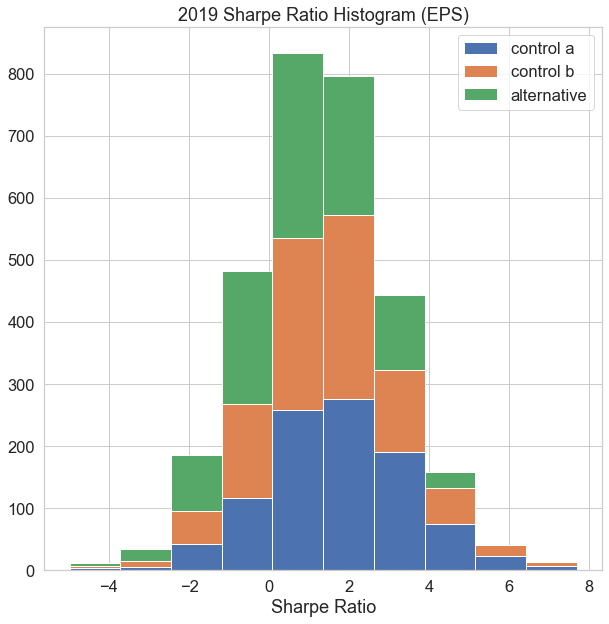

In [112]:
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(x=[sharpe_data['control a'], sharpe_data['control b'], sharpe_data['alternative']],
                            histtype='barstacked', alpha = 1)

plt.xlabel('Sharpe Ratio')
plt.title('2019 Sharpe Ratio Histogram (' +metric+')')
plt.legend(['control a', 'control b', 'alternative'])
plt.show()

Text(0.5, 1.0, '2019 Sharpe Ratio Distributions (EPS)')

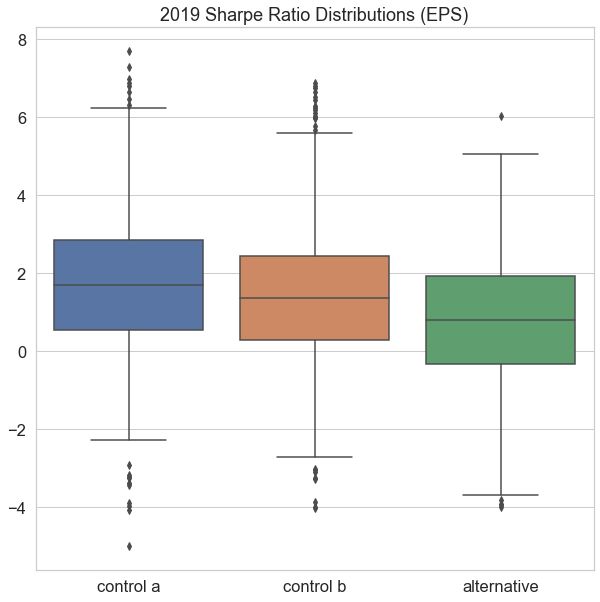

In [113]:
# draw boxplots, QQplot and comment on data

# boxplot looks normally distributed
sns.set(style = 'whitegrid', font_scale=1.5)
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=sharpe_data)
plt.title('2019 Sharpe Ratio Distributions (' +metric+')')

### Returns

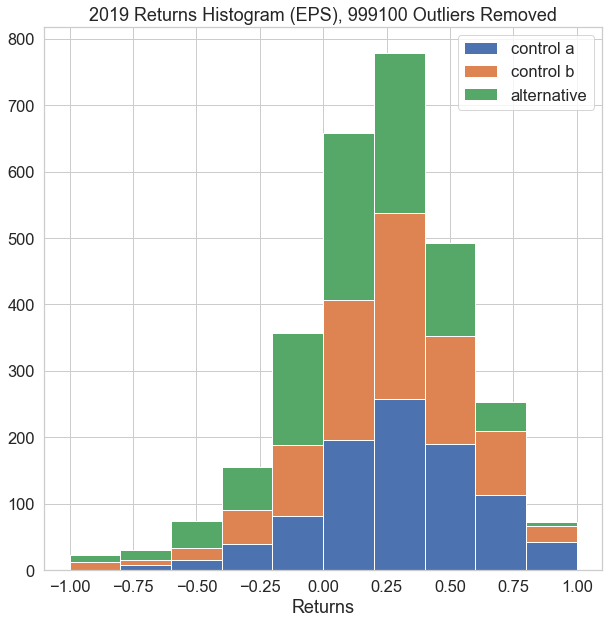

In [115]:
threshold = 1

plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(x=[return_data['control a'], return_data['control b'], return_data['alternative']],
                            histtype='barstacked', alpha = 1, range = (-1, 1))

hist_return_outlier = return_data[(return_data['alternative'] < threshold) & (return_data['alternative'] >-threshold) 
                             & (return_data['control b'] < threshold) & (return_data['control b'] > -threshold) 
                             & (return_data['control a'] > -threshold)& (return_data['control a'] < threshold)]

plt.xlabel('Returns')
plt.title('2019 Returns Histogram (' +metric+'), {} Outliers Removed'.format(1000000 - len(hist_return_outlier)))
plt.legend(['control a', 'control b', 'alternative'])
plt.show()

Text(0.5, 1.0, '2019 Returns Distributions (EPS)')

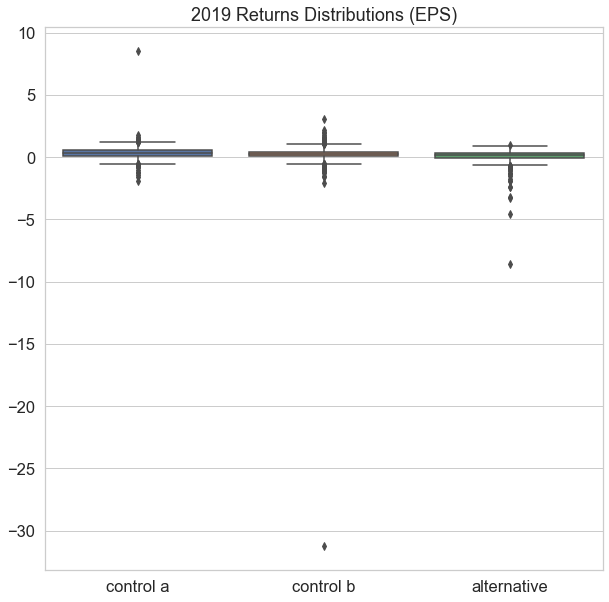

In [116]:
# outliers are skewing the plot

plt.figure(figsize=(10,10))
ax = sns.boxplot(data=return_data)
plt.title('2019 Returns Distributions (' +metric+')')

number of outliers removed: 999012


Text(0.5, 1.0, '2019 Returns Distributions (EPS), 999012 Outliers Removed)')

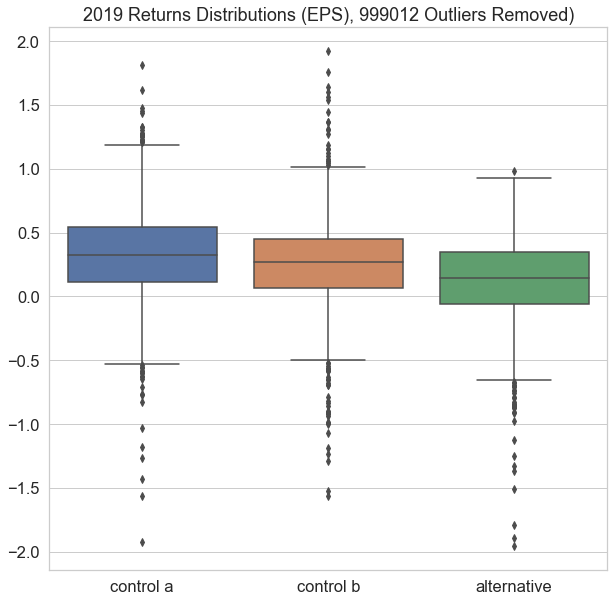

In [117]:
# returns boxplot with outliers greater and less than threshold
threshold = 2
return_outlier = return_data[(return_data['alternative'] < threshold) & (return_data['alternative'] >-threshold) 
                             & (return_data['control b'] < threshold) & (return_data['control b'] > -threshold) 
                             & (return_data['control a'] > -threshold)& (return_data['control a'] < threshold)]
print('number of outliers removed: {}'.format(1000000 - len(return_outlier)))
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=return_outlier)
plt.title('2019 Returns Distributions (' +metric+'), {} Outliers Removed)'.format(1000000 - len(return_outlier)))

### Risk

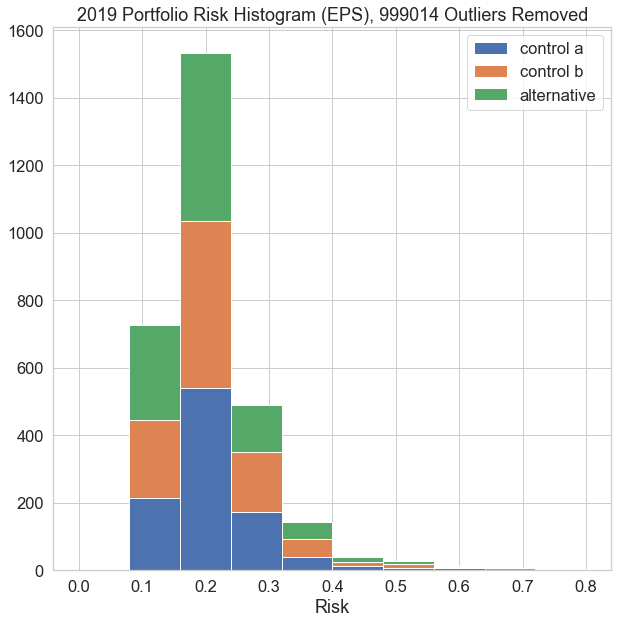

In [119]:
threshold=0.8

plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(x=[risk_data['control a'], risk_data['control b'], risk_data['alternative']],
                            histtype='barstacked', alpha = 1, range=(0,0.8))

hist_risk_outlier = risk_data[(risk_data['alternative'] < threshold) & (risk_data['alternative'] >-threshold) 
                             & (risk_data['control b'] < threshold) & (risk_data['control b'] > -threshold) 
                             & (risk_data['control a'] > -threshold)& (risk_data['control a'] < threshold)]

plt.xlabel('Risk')
plt.title('2019 Portfolio Risk Histogram (' +metric+'), {} Outliers Removed'.format(1000000 - len(hist_risk_outlier)))
plt.legend(['control a', 'control b', 'alternative'])
plt.show()

Text(0.5, 1.0, '2019 Risk Distributions')

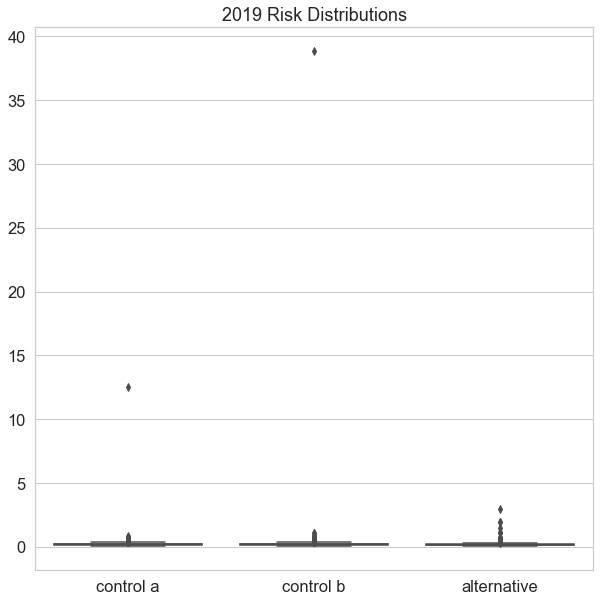

In [26]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=risk_data)
plt.title('2019 Risk Distributions')

number of outliers removed: 999003


Text(0.5, 1.0, '2019 Risk Distributions (EPS), 999003 Outliers Removed')

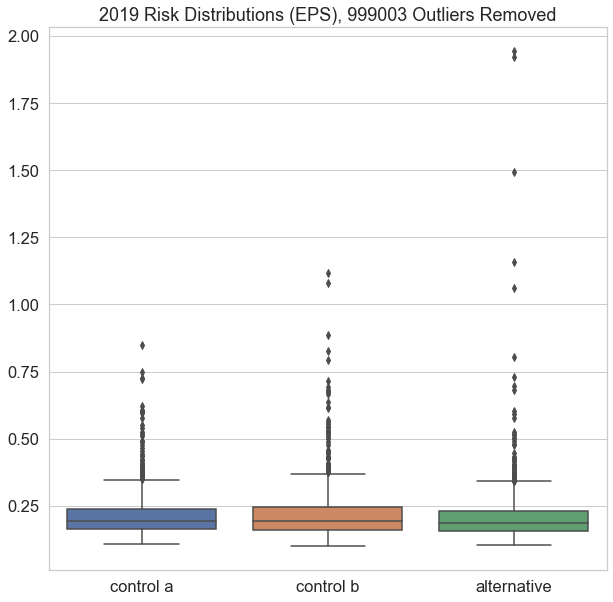

In [120]:
threshold = 2
risk_outlier = risk_data[(risk_data['alternative'] < threshold) & (risk_data['alternative'] >-threshold) 
                             & (risk_data['control b'] < threshold) & (risk_data['control b'] > -threshold) 
                             & (risk_data['control a'] > -threshold)& (risk_data['control a'] < threshold)]
print('number of outliers removed: {}'.format(1000000 - len(risk_outlier)))
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=risk_outlier)
plt.title('2019 Risk Distributions (' +metric+'), {} Outliers Removed'.format(1000000 - len(risk_outlier)))

## Statistical Inference - Control A

In [101]:
# find 95% confidence interval and interpret

def one_sided_confidence_interval(data_con, data_alt):
    data = data_alt-data_con
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * 1.65
    return float('-inf'), m+h

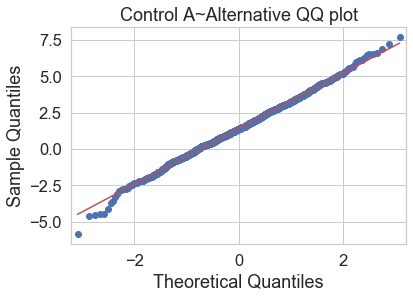

normality test for control: (0.9974433779716492, 0.11838006228208542)
normality test for alternative: (0.9978559017181396, 0.22742991149425507)
2 sample z test, alpha=0.05. (Z-score, p-value): (-11.471250512428895, 1.0)


Since p-value is greater than alpha, fail to reject null hypothesis.
95% Confidence Interval: (-inf, -0.7519716059029227)


In [106]:
# qq plot
mod_fit = sm.OLS(sharpe_data['control a'], sharpe_data['alternative']).fit()
res=mod_fit.resid
fig=sm.qqplot(res, line='s')
plt.title('Control A~Alternative QQ plot')
plt.show()

# test for normality shapiro wilk
# high W score implies normality

print('normality test for control: {}'.format(stats.shapiro(sharpe_data['control a'])))
print('normality test for alternative: {}'.format(stats.shapiro(sharpe_data['alternative'])))

# unnecessary since large sample

#stats.levene(sharpe_data['control a'], sharpe_data['alternative'], center='mean')

# 2 sample z test since n > 30

print('2 sample z test, alpha=0.05. (Z-score, p-value): {}'.format(ztest(sharpe_data['alternative'], x2=sharpe_data['control a'], alternative='larger')))
print('\n')
print('Since p-value is greater than alpha, fail to reject null hypothesis.')
print('95% Confidence Interval: {}'.format(mean_confidence_interval(sharpe_data['control a'], sharpe_data['alternative'])))

## Statistical Inference - Control B

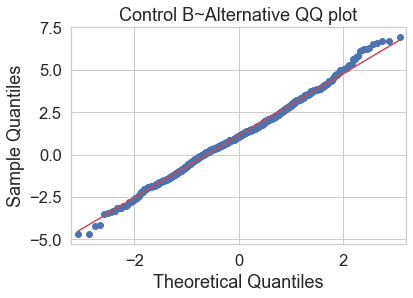

normality test for control: (0.9957621693611145, 0.007454112637788057)
normality test for alternative: (0.9978559017181396, 0.22742991149425507)
2 sample z test, alpha=0.05. (Z-score, p-value): (-7.5269884315812625, 0.999999999999974)


Since p-value is greater than alpha, fail to reject null hypothesis.
95% Confidence Interval: (-inf, -0.44622410691158987)


In [107]:
# qq plot
mod_fit = sm.OLS(sharpe_data['control b'], sharpe_data['alternative']).fit()
res=mod_fit.resid
fig=sm.qqplot(res, line='s')
plt.title('Control B~Alternative QQ plot')
plt.show()

# test for normality shapiro wilk
# high W score implies normality

print('normality test for control: {}'.format(stats.shapiro(sharpe_data['control b'])))
print('normality test for alternative: {}'.format(stats.shapiro(sharpe_data['alternative'])))

# unnecessary since large sample

#stats.levene(sharpe_data['control b'], sharpe_data['alternative'], center='mean')

# 2 sample z test since n > 30

print('2 sample z test, alpha=0.05. (Z-score, p-value): {}'.format(ztest(sharpe_data['alternative'], x2=sharpe_data['control b'], alternative='larger')))
print('\n')
print('Since p-value is greater than alpha, fail to reject null hypothesis.')
print('95% Confidence Interval: {}'.format(mean_confidence_interval(sharpe_data['control b'], sharpe_data['alternative'])))

# Hypothesis 2: Recession Data

## Testing Code